In [1]:
import copy as cp
import numpy as np
from docx import Document as doc
import matplotlib as mt
import matplotlib.pyplot as plt
from tqdm import tqdm
import logomaker
import pandas as pd

### functions

In [2]:
def get_seq(s):
    # confirm atleast 2 entries (gene and sequence)
    assert len(s) > 1
    
    # id check
    gene = is_id(s[0])
    
    # getting seq
    seq = ''
    for i in s[1:]:
        seq += is_seq(i)
        
    return gene, seq



def is_id(x, wanr=True):
    if x[:4].upper() == '>CYP':
        return x.split()[0]
    else:
        if warn:
            raise ValueError('not an id')
            
            
def is_seq(x):
    if x.isalpha():
        seq = x
    elif x.replace(" ", "").replace("*", "").isalpha():
        seq = x.replace(" ", "")
    elif len(x.split())>1:
        seq=''
        for i in x.split():
            if i.isalpha():
                seq += i
    elif x.replace(" ", "").replace("*", "") == '':
        seq = ''
    else:
        raise ValueError('not a seq')
        
    if seq.isupper():
        return seq
    else:
        return ''
    

def alternate_seq(s):
    s = s[0].upper().split()
    return get_seq(s)


def get_probs(aln, 
              main='CYP101A1', 
              in_start=231, in_end=260, out_start=234, out_end=260,
              consider_gap=False, return_raw=False, return_dataframe=True):
    '''
    This function calculates the probabilities of residues at each position, given a portion of MSA.
    The probabilities are calculated only for main sequence, thereby ignoring positions if empty in main.
    If consider_gap == True, then the '-' (missing) is also count a vaid entry while estimating probabilties.
    if return_raw, then probabilties are not estimated.
    '''
    res = {'G':0, 'A':1, 'V':2, 'L':3, 'I':4, 'M':5, 'P':6,
          'S':7, 'T':8, 'N':9, 'Q':10, 'C':11,
          'D':12, 'E':13, 'H':14, 'K':15, 'R':16,
          'W':17, 'Y':18, 'F':19, '-':20}
    #
    main = aln[aln[:,0]==main][0][1]
    #
    probs = []
    for i in range(len(main)):
        if main[i] != '-':
            probi = np.zeros(len(res))
            for j in range(len(aln)):
                probi[ res[ aln[j][1][i] ] ] += 1
            probs.append(probi)
    probs = np.array(probs)
    #
    if out_end<in_end:
        probs = probs[out_start-in_start:out_end-in_end]
    else:
        probs = probs[out_start-in_start:]
    if not consider_gap:
        probs = probs[:,:-1]
    
    if not return_raw:
        probs = probs/np.sum(probs, axis=1)[:,None]
    #
    if return_dataframe:
        return pd.DataFrame(probs, 
                            index=np.arange(out_start,out_end+1), 
                            columns=list(res.keys())[:probs.shape[1]]
                           )
    else:
        return probs

### reading seqs

In [3]:
raw = doc('msa/bacterial_p450_raw.docx')

In [4]:
for a,para in enumerate(raw.paragraphs):
    print(para.text)
    if a>3:break

>CYP51B1    Mycobacterium tuberculosis (Actinobacteria) Rv0764c
MSAVALPRVSGGHDEHGHLEEFRTDPIGLMQRVRDECGDVGTFQ
LAGKQVVLLSGSHANEFFFRAGDDDLDQAKAYPFMTPIFGEGVVFDASPERRKEMLHN
AALRGEQMKGHAATIEDQVRRMIADWGEAGEIDLLDFFAELTIYTSSACLIGKKFRDQ
LDGRFAKLYHELERGTDPLAYVDPYLPIESFRRRDEARNGLVALVADIMNGRIANPPT


In [5]:
seqs = []
entry=[]

for line in raw.paragraphs:
    text = line.text
    
    if text != '':
        entry.append(text)
    else:
        seqs.append(entry)
        entry = []
    

In [6]:
len(seqs)

1153

In [7]:
seqs[0]

['>CYP51B1    Mycobacterium tuberculosis (Actinobacteria) Rv0764c',
 'MSAVALPRVSGGHDEHGHLEEFRTDPIGLMQRVRDECGDVGTFQ',
 'LAGKQVVLLSGSHANEFFFRAGDDDLDQAKAYPFMTPIFGEGVVFDASPERRKEMLHN',
 'AALRGEQMKGHAATIEDQVRRMIADWGEAGEIDLLDFFAELTIYTSSACLIGKKFRDQ',
 'LDGRFAKLYHELERGTDPLAYVDPYLPIESFRRRDEARNGLVALVADIMNGRIANPPT',
 'DKSDRDMLDVLIAVKAETGTPRFSADEITGMFISMMFAGHHTSSGTASWTLIELMRHR',
 'DAYAAVIDELDELYGDGRSVSFHALRQIPQLENVLKETLRLHPPLIILMRVAKGEFEV',
 'QGHRIHEGDLVAASPAISNRIPEDFPDPHDFVPARYEQPRQEDLLNRWTWIPFGAGRH',
 'RCVGAAFAIMQIKAIFSVLLREYEFEMAQPPESYRNDHSKMVVQLAQPACVRYRRRTG',
 'V']

### checking readable format

In [8]:
readable = []
bads = []
for a,s in enumerate(seqs):
    try:
        readable.append(get_seq(s))
    except:
        bads.append(a)

In [9]:
len(readable), len(bads)

(1147, 6)

In [10]:
readable.append(alternate_seq(seqs[bads[1]]))
readable.append(alternate_seq(seqs[bads[2]]))

In [11]:
seqs[bads[0]]

['>CYP107L7P   Streptomyces narbonensis',
 'MSRTHQGTTASRPVLDLAALGQDFAADPYPTYARLRAEGPAHRV',
 'RTPEGDEVWLVVGYDTARAVLADPRFSKDWRNSATPPTEAEAALSHNMLESDPRCGPT',
 '(deletion)',
 'ALRADLTLLDGAVEEMLRYGGPVESATYRFPVEPVDLDGTVLPAGETVLVVLAD',
 'AHRTPERFPDPHRFDIRRDTAGHLAFGHGIHFCTGAPLARMEARIAVRALLERCPDLALD',
 'VSPGELFWYPNPMIRGLESLPIRWRSGREAGRRVPVEPACRP*']

In [12]:
seqs[bads[3]], seqs[bads[5]]

([], [])

In [13]:
seqs[bads[4]]

['MAAVPEPIVLVPGKSREQALQLREAGPL',
 'ARVVVEGLEVWALTHDRELREALIDPRFRRNWRTWRALNEGEVATDHPVAAMVYLDNM',
 'LTVDGEAHRRMRSPVAQAFTPRRVELLRPRVTEIVNALLDQLAERDGTVDFKTEFAYP',
 'LSMRVFSALFGIPERDHGRMQQMVNTAFSPSSPEEVRAMREELDAFLDELIEDKRRSP',
 'GEDLTSALVTATDEEHKLSDAELRDTLWLLVTAGFETTSSALANAVQTLLTHPDQLAH',
 'LRSGSIAWEDAIEEVLRQSSSVATLPFLFAAEDVQIGDRTIRAGEPVLLAYLAANLDV',
 'ERYGEDAAEFDATQSRPRHLAFGHGPHTCLGAALARLEMEVALTTLFTEFPEVSLAEG',
 'EAPRLESVFIHAPAALPIRLGPRRTAA']

### final check

In [14]:
len(readable)

1149

In [15]:
lengths = np.array([len(i[1]) for i in readable])

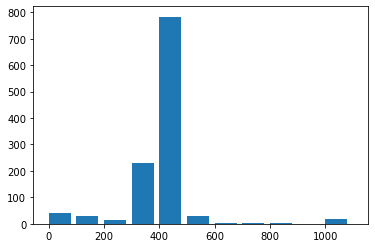

In [16]:
plt.hist(lengths, bins=np.arange(0,1200, 100), width=80,)
plt.show()

In [17]:
reasonable = np.where((lengths>=300)&(lengths<=500))[0]
len(reasonable)

1013

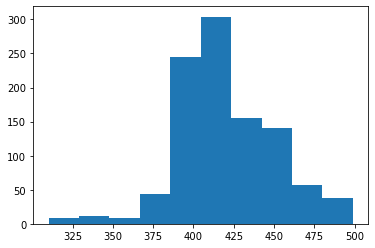

In [18]:
plt.hist(lengths[reasonable])
plt.show()

### writing aln file

In [19]:
ids=np.array([i[0] for i in readable])
np.where(ids=='>CYP101A1')

(array([10]),)

In [20]:
readable[0], readable[10] = readable[10], readable[0]

In [29]:
afile = open('msa/bacterial_p450_.aln', 'w')
genes = []
for i in tqdm(reasonable):
    gene, seq = readable[i]
    #
    if gene not in genes:
        name = gene
        genes.append(name)
    else:
        g=1
        name = gene
        while name in genes:
            name = f'{gene}_{g}'
            g += 1
        genes.append(name)
        
    #
    afile.write(f'{name}\n{seq}\n')
afile.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1013/1013 [00:00<00:00, 37419.46it/s]


### plotting alignement

In [21]:
aln = np.loadtxt('msa/extracted_clustal_output.aln', dtype=str)

In [22]:
probs=get_probs(aln, out_start=235, out_end=257)

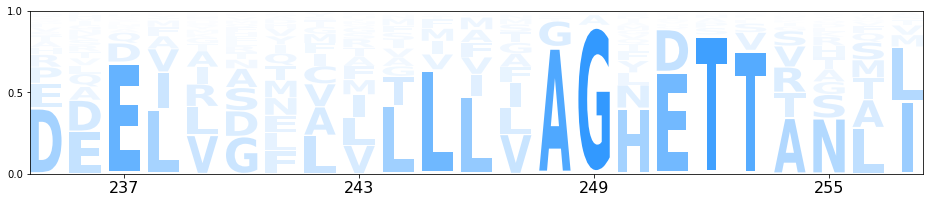

In [130]:
fig,ax=plt.subplots(1, figsize=(16,3))
slogo = logomaker.Logo(probs,
                         ax=ax,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top',
                         color_scheme='dodgerblue',
                         font_name='Rosewood Std')
slogo.ax.set_yticks([0, .5, 1])
slogo.ax.set_xticks([237,243,249,255])
slogo.ax.tick_params(axis='x', labelsize=16)
plt.savefig('msa/msa_i.pdf')
plt.show()

In [23]:
probs

,G,A,V,L,I,M,P,S,T,N,Q,C,D,E,H,K,R,W,Y,F
235,0.015690,0.038703,0.026151,0.020921,0.011506,0.005230,0.099372,0.027197,0.030335,0.010460,0.012552,0.000000,0.403766,0.151674,0.043933,0.009414,0.076360,0.002092,0.003138,0.011506
236,0.027750,0.082260,0.043608,0.051536,0.021804,0.020813,0.018831,0.034688,0.041625,0.029732,0.079286,0.000000,0.191278,0.260654,0.019822,0.033697,0.036670,0.000000,0.001982,0.003964
237,0.004255,0.021277,0.010638,0.011702,0.004255,0.000000,0.000000,0.010638,0.007447,0.014894,0.064894,0.000000,0.117021,0.685106,0.007447,0.008511,0.014894,0.001064,0.010638,0.005319
238,0.001064,0.077660,0.142553,0.396809,0.227660,0.039362,0.000000,0.002128,0.014894,0.000000,0.004255,0.007447,0.001064,0.002128,0.000000,0.004255,0.007447,0.000000,0.014894,0.056383
239,0.036816,0.099502,0.236816,0.176119,0.104478,0.023881,0.008955,0.018905,0.044776,0.009950,0.012935,0.006965,0.006965,0.009950,0.012935,0.024876,0.137313,0.000000,0.020896,0.006965
240,0.228940,0.116947,0.019822,0.030723,0.008920,0.020813,0.009911,0.142716,0.044599,0.054509,0.021804,0.001982,0.157582,0.029732,0.026759,0.003964,0.038652,0.002973,0.011893,0.026759
241,0.000000,0.017839,0.048563,0.110010,0.052527,0.106046,0.001982,0.016848,0.092170,0.107037,0.075322,0.006938,0.026759,0.108028,0.027750,0.000000,0.000991,0.007929,0.051536,0.141724
242,0.042616,0.175421,0.140733,0.235877,0.076313,0.057483,0.001982,0.022795,0.040634,0.000000,0.003964,0.110010,0.000000,0.000000,0.000000,0.000000,0.000991,0.005946,0.022795,0.062438
243,0.033697,0.060456,0.175421,0.168484,0.141724,0.091179,0.000000,0.036670,0.054509,0.017839,0.020813,0.008920,0.005946,0.006938,0.013875,0.005946,0.052527,0.004955,0.016848,0.083251
244,0.061000,0.055000,0.054000,0.418000,0.050000,0.043000,0.001000,0.047000,0.181000,0.021000,0.011000,0.000000,0.005000,0.002000,0.003000,0.000000,0.002000,0.000000,0.003000,0.043000


## humans

### raw data from cytochrome P450 homepage

In [14]:
raw = []
entry=[]
for line in open('msa/humans_cyp_homepage.fasta', 'r'):
    items = line.strip().split()
    if len(items)==0:
        raw.append(entry)
        entry = []
    else:
        entry.append(line.strip())

In [15]:
len(raw)

268

### getting readbale format

In [27]:
readable = []
bads = []
for a,s in enumerate(raw):
    try:
        readable.append(get_seq(s))
    except:
        bads.append(a)

In [28]:
len(readable), len(bads)

(188, 80)

188 is actually ids in raw data (if checked grep '>CYP' humans_cyp_homepage.fasta  | wc -l)

In [51]:
for a in bads:
    print(raw[a])
    print('\n\n')

['>Another 2A Separate C-term on AC008537.5 minus strand missing exons 6, 8', '105289 MLASGLLLVALLACLTVMVLMSVWQQRKSRGKLPPGPTPLPFIGNYLQLNTEHICDSIMK 105110', '104830 FSECYGPVFTIHLGPRRVVVLCGHDAVREALVDQAEEFSGRGEQATFDWVFKGY 104669', '103708 GVAFSNGERAKQLLRFAIATLRDFGVGKRGIEERIQEESGFLIEAIRSTH 103559', '103324 GANIDPTFFLSRTVSNVISSIVFGDRFDYEDKEFLSLLSMMLGIFQFTSTSTGQ 103163', '102015 LYEMFSSVMKHLPGPQQQAFKLLQGLEDFIAKKVEHNQRTLDPNSPQDFIDSFLIHMQE 101839', '100457 AKVHEEIDRVIGKNRQPKFEDRTKMPYMEAVIHEIQRFGDVIPMSLARRVKKDTKFRDFFLPK 100269']



['98951 KRNCFGEGLARMELFLFFTTVMQNFRLKSSQSPKDIDVSPKHVVFATIPRNYTMSFLP 98778']



['>2A7 related Separate C-term on AC008537.3 minus strand missing exons 3, 6, 8', 'MLASGLLLVALLACLTVMVLMSVWQQRKSRGKLPPGPTPLPFIGNYLQLNTEHICDSIMK', 'FSECYGPVFTIHLGPRRVVVLCGHDAVREALVDQAEEFSGRGEQATFDWVFKGY', 'GANIDPTFFLSRTVSNVISSIVFGDRFDYEDKEFLSLLSMMLGIFQFTSTSTGQ', 'LYEMFSSVMKHLPGPQQQAFKLLQGLEDFIAKKVEHNQRTLDPNSPQDFIDSFLIHMQE', 'AKVHEEIDRVIGKNRQPKFEDRTKMPYMEAVIHEIQRFGDVIPMSLARRVKKDTKFRDFFLPK', '

the bads identified are different forms/alleles of one or more P450s

### final check

In [53]:
lengths = np.array([len(i[1]) for i in readable])

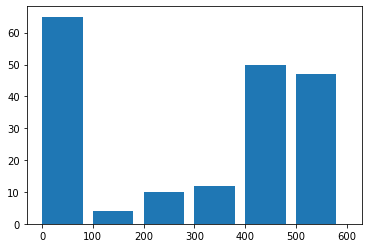

In [57]:
plt.hist(lengths, bins=np.arange(0,700, 100), width=80,)
plt.show()

In [60]:
reasonable = np.where((lengths>=400)&(lengths<=600))[0]
len(reasonable)

97

In [71]:
importants = ['1A2', '2D6', '2E1', '2C8', '2C9', '2C19', '2A6', '2B6', '3A4']
for a in readable:
    if a[0][4:] in importants:
        print(a[0], len(a[1]))

>CYP1A2 515
>CYP2A6 494
>CYP2A6 494
>CYP2B6 492
>CYP2B6 433
>CYP2C8 490
>CYP2C8 430
>CYP2C9 490
>CYP2C9 430
>CYP2C19 490
>CYP2C19 430
>CYP2D6 497
>CYP2E1 493
>CYP3A4 502
>CYP3A4 503


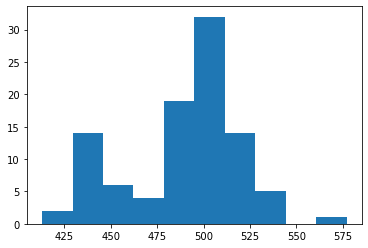

In [72]:
plt.hist(lengths[reasonable])
plt.show()

### writing aln file

In [74]:
afile = open('msa/humans_p450_.aln', 'w')
genes = []
for i in tqdm(reasonable):
    gene, seq = readable[i]
    #
    if gene not in genes:
        name = gene
        genes.append(name)
    else:
        g=1
        name = gene
        while name in genes:
            name = f'{gene}_{g}'
            g += 1
        genes.append(name)
        
    #
    afile.write(f'{name}\n{seq}\n')
afile.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 86858.99it/s]


### plotting alignement

In [24]:
aln = np.loadtxt('msa/humans_extracted_clustal_output.aln', dtype=str)

In [25]:
probs=get_probs(aln, 
                main='CYP3A4', 
                in_start=297, in_end=343, 
                out_start=297, out_end=315)

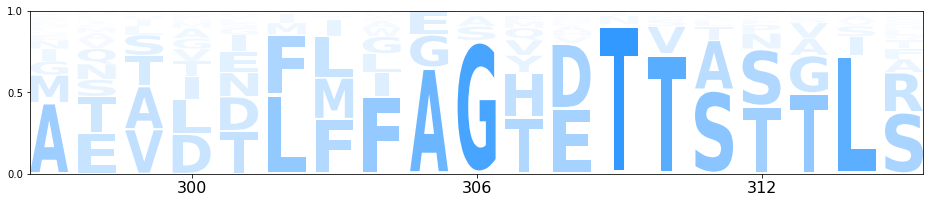

In [28]:
fig,ax=plt.subplots(1, figsize=(16,3))
slogo = logomaker.Logo(probs,
                         ax=ax,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top',
                         color_scheme='dodgerblue',
                         font_name='Rosewood Std')
slogo.ax.set_yticks([0, .5, 1])
slogo.ax.set_xticks([300,306,312])
slogo.ax.tick_params(axis='x', labelsize=16)
plt.savefig('msa/humans_msa_i.pdf')
plt.show()

In [26]:
probs

,G,A,V,L,I,M,P,S,T,N,Q,C,D,E,H,K,R,W,Y,F
297,0.085106,0.436170,0.010638,0.021277,0.074468,0.170213,0.000000,0.000000,0.010638,0.053191,0.021277,0.010638,0.021277,0.031915,0.000000,0.021277,0.010638,0.000000,0.010638,0.010638
298,0.010526,0.042105,0.052632,0.010526,0.021053,0.031579,0.000000,0.105263,0.221053,0.094737,0.094737,0.021053,0.010526,0.252632,0.010526,0.000000,0.000000,0.000000,0.010526,0.010526
299,0.010526,0.263158,0.273684,0.052632,0.042105,0.000000,0.000000,0.126316,0.189474,0.010526,0.000000,0.000000,0.000000,0.000000,0.021053,0.000000,0.000000,0.000000,0.000000,0.010526
300,0.063830,0.063830,0.074468,0.212766,0.138298,0.031915,0.010638,0.000000,0.095745,0.010638,0.000000,0.000000,0.244681,0.000000,0.021277,0.010638,0.000000,0.000000,0.000000,0.021277
301,0.042105,0.000000,0.010526,0.021053,0.105263,0.010526,0.000000,0.031579,0.263158,0.147368,0.000000,0.000000,0.210526,0.126316,0.010526,0.000000,0.000000,0.000000,0.021053,0.000000
302,0.000000,0.000000,0.010526,0.484211,0.052632,0.073684,0.000000,0.000000,0.000000,0.000000,0.010526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.368421
303,0.000000,0.000000,0.010526,0.252632,0.105263,0.252632,0.000000,0.010526,0.021053,0.000000,0.010526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.336842
304,0.105263,0.042105,0.021053,0.115789,0.147368,0.021053,0.000000,0.021053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.473684
305,0.200000,0.652632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147368,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
306,0.819149,0.063830,0.010638,0.000000,0.000000,0.000000,0.000000,0.085106,0.010638,0.000000,0.000000,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
